This notebook explores very basics of BO by implementing one from ground up using Numpy, Scipy for optimization and Scikit-learn for GPs. This notebook very closely follows this blog post: http://krasserm.github.io/2018/03/19/gaussian-processes/

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

We are going to work with a noisy 1d function, within the domain given by `bounds`. To initialize the BO loop we will use two initial points.

In [2]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

Let's plot the function, just to see what it looks like. We show both noisy and noise-free evaluations.

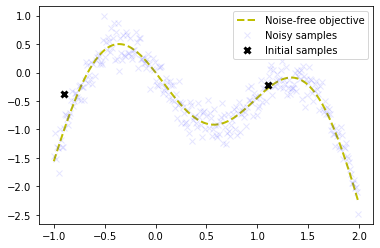

In [3]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

Here we implement the Expected Improvement acquisition function. It is defined as

$$ EI(x) = \mathbb{E} max(f(x)−f(x^+), 0) $$

where $x^+$ is the point of currently known max, according to the model. So it is a max of math expectation of getting a new point that gives the biggest value difference over current max, or 0 if such difference is negative. _Question_: why not just have negative values, is it somehow important for derivations?

The expectation can be evaluated analytically for GP:

$$EI(x)=\left\{
                \begin{array}{ll}
                  (\mu(x) - f(x^+) - \xi) \Phi(Z) + \sigma(x)\phi(Z), \sigma(x) \geq 0\\
                  0, \sigma(x) < 0
                \end{array}
        \right.$$
              
Where

$$Z(x)=\left\{
               \begin{array}{ll}
                 \frac{\mu(x) - f(x^+) - \xi}{\sigma{x}}, \sigma(x) > 0\\
                 0, \sigma(x) = 0
               \end{array}
       \right.$$

and $\Phi$ and $\phi$ are the CDF and PDF of the standard normal distribution, respectively, and $\xi$ is the hyperparameter. $\mu(x)$ and $\sigma(x)$ are mean and standard deviation of the current model.

The first equation makes it very clear how exploitation and exploration are balanced. First sum term depends on mean of the current model, so it concerns itself with function values. Second sum term depends on standard deviation, so it concerns itself with variation of the model, essentially getting bigger where model knows less about function's behavior. $\xi$ is what we subtract from the first term, decreasing the exploitation. The bigger this parameter is, the more we encourage exploration.

In [4]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A scikit-learn GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    # Here we just compute statistics from the model
    # reshape is needed to broadcast operations down the line
    mu, sigma = gpr.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)
    
    # This we need to find out what's current max, according to the model
    # It is only needed for noise-based model. For noise free we could use np.max(Y_sample).
    mu_sample = gpr.predict(X_sample)
    mu_sample_opt = np.max(mu_sample)
    
    
    # context manager here to avoid failing hard in case of numerical instabilities
    # shouldn't happen often
    with np.errstate(divide='warn'):
        # this is just plain implementation of the formulas above, nothing fancy
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

Acquisition function needs to be optimized, and we use it's max to propose next point to evaluate real objective. Function below uses scipy to optimize the acquisition. Optimization process is restarted multiple times from random locations to make sure we avoid getting stuck at the local minimum.

In [5]:
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A scikit-learn GaussianProcessRegressor fitted to samples.
        bounds: Domain bounds over which optimization is done
        n_restarts: how many times to restart optimization

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = float('inf')
    min_x = None
    
    def min_obj(X):
        # Scipy minimizes, and we want to maximize
        # Thus we negate the acquisition function
        
        # ravel at the end because scipy needs 1d output, and fails if it is Nx1 for example
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr).ravel()
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        # there is no need to store results from previous attempts
        # simply replace one, if that is better than before
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
    
    # we could also return -min_val if we wanted the max value of acquisitio
    return min_x.reshape(-1, 1)

Now we can define the whole BO loop.

First some utility functions for plotting

In [6]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    
    # 1.96 comes from the normal distribution
    # mean +-1.96 stdev covers 95% of the area under bell curve
    # so here we use it to plot 95% confidence intervals
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    
    # this line shows where the current acqusition max is, and thus where the next evaluation will be
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next evaluation point')
        
    # only to show legend at the first plot
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    # current max of the acquisition
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    
    # only to show legend at the first plot
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    # we can use this data to show how much optimization jumped between different parts of the domain
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    
    # this is also known as best fo far or current best
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

Now the optimization loop itself. We use GP with Matern kernel from scikit-learn. At each step we plot the current state of the model and the acquisition, illustrating where the next point will be and why.

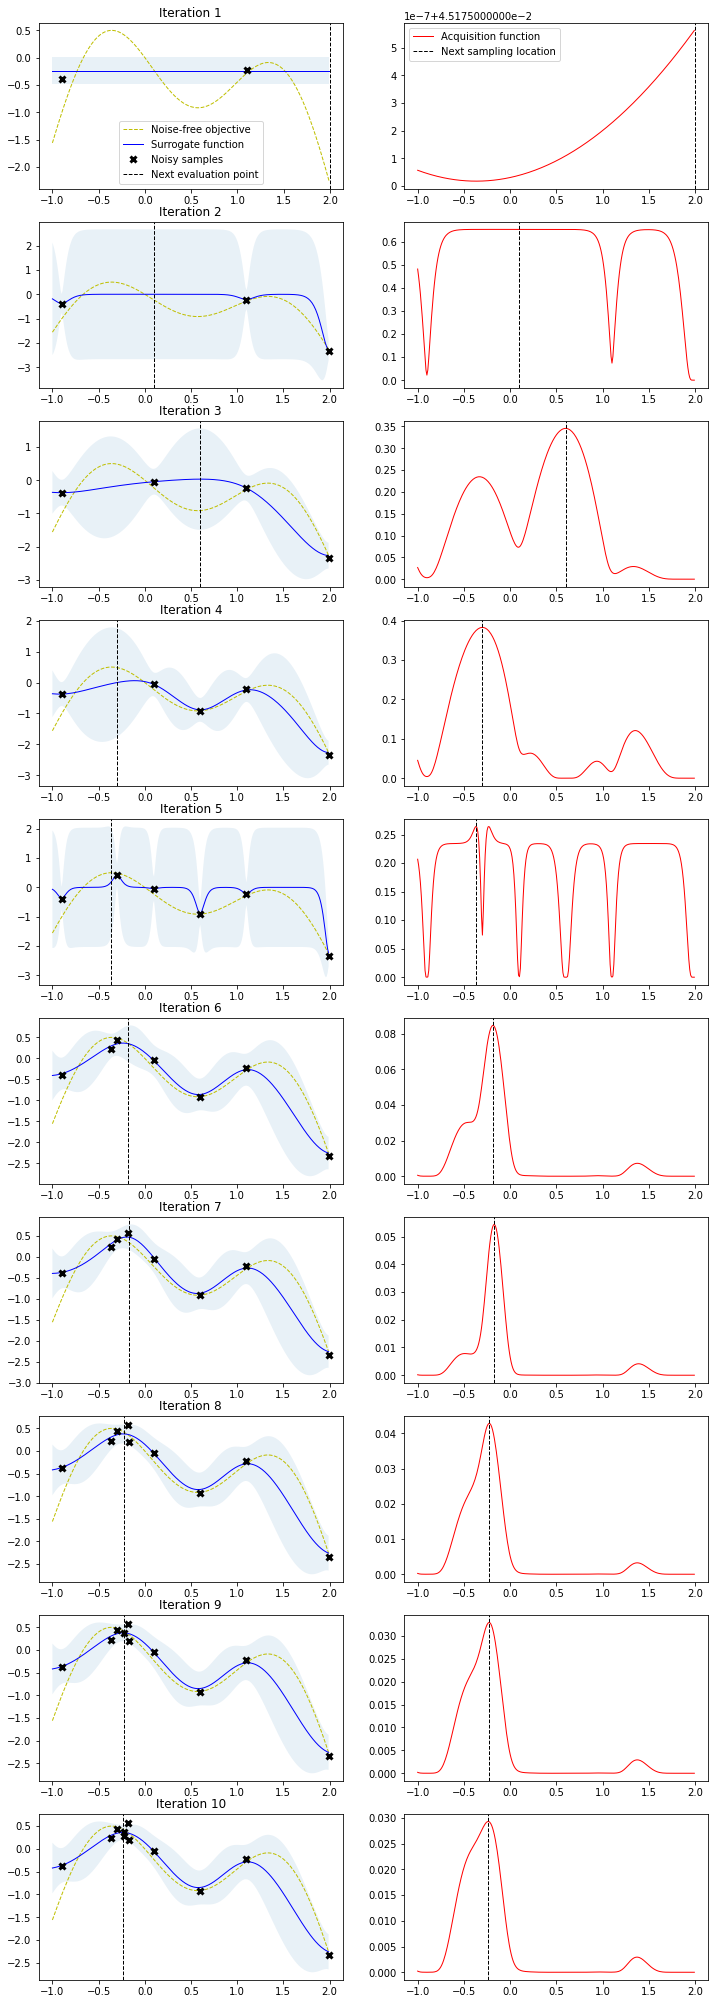

In [7]:
# jupyter outputs really tiny plots for some reason
# increase their size globally
plt.rcParams['figure.figsize'] = [12, 36]

# Gaussian process with Matern kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=(i==0))
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

After the run we can also analyze convergence. First plot shows how the difference between consecutive Xs changed, essentially how much the optimization jumped between different points of the domain. Second plot shows current best value at each iteration.

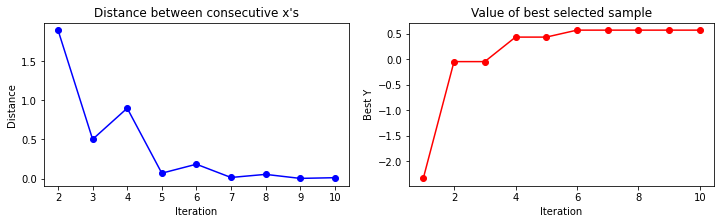

In [8]:
plot_convergence(X_sample, Y_sample)